In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import traceback

# Configurar o TensorFlow para usar menos memória
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# --- Função para carregar dados (MESMA DO LSTM) ---
def carregar_dados_ticker(ticker, pasta_dados_tratados):
    """Carrega dados pré-processados, renomeia colunas e trata NaNs."""
    nome_arquivo = f"{ticker}_dados_macro_micro.csv"
    caminho_arquivo = os.path.join(pasta_dados_tratados, nome_arquivo)

    if not os.path.exists(caminho_arquivo):
        print(f"Erro: Arquivo não encontrado para {ticker} em {caminho_arquivo}")
        return None, None, None

    try:
        print(f"Carregando dados tratados de: {caminho_arquivo}")
        try:
            df = pd.read_csv(caminho_arquivo, index_col=0)
            df.index = pd.to_datetime(df.index)
        except Exception as e:
            print(f"Erro ao carregar arquivo: {e}")
            return None, None, None

        print("Colunas originais:", df.columns.tolist())

        # Identificar colunas de preço alvo
        target_col = None
        if 'Close_Target' in df.columns:
            target_col = 'Close_Target'
        elif 'Preço' in df.columns:
            target_col = 'Preço'
        else:
            print(f"Erro: Nenhuma coluna de preço alvo encontrada para {ticker}")
            return None, None, None

        # Identificar a coluna de feature de preço
        feature_cols = []
        price_feature_col = None
        
        if 'Close_Feature' in df.columns:
            price_feature_col = 'Close_Feature'
        elif 'Preço_anterior' in df.columns:
            price_feature_col = 'Preço_anterior'
        else:
            print(f"Aviso: Nenhuma coluna de preço anterior encontrada para {ticker}")
        
        if price_feature_col:
            feature_cols.append(price_feature_col)

        # Separar features macro e micro
        macro_cols = ['TaxaCambio', 'Selic', 'PIB', 'IPCA']
        micro_cols = ['ROA', 'ROE', 'Margem Líquida', 'P/L', 'VP']

        # Adicionar features disponíveis
        for col in macro_cols + micro_cols:
            if col in df.columns:
                feature_cols.append(col)

        if len(feature_cols) < 2:
            print(f"Aviso: Poucas features encontradas para {ticker}: {feature_cols}")

        print(f"Features identificadas para {ticker}: {feature_cols}")
        print(f"Target identificado para {ticker}: {target_col}")

        # Tratar NaNs
        df = df[feature_cols + [target_col]].copy()
        df.dropna(subset=[target_col], inplace=True)
        
        for col in feature_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df[feature_cols] = df[feature_cols].fillna(method='ffill')
        if df[feature_cols].isnull().any().any():
            df[feature_cols] = df[feature_cols].fillna(method='bfill')
        
        if df[feature_cols + [target_col]].isnull().any().any():
            print(f"Aviso: Ainda existem NaNs para {ticker}. Removendo linhas afetadas...")
            df.dropna(inplace=True)

        print(f"Dimensões finais do DataFrame para {ticker}: {df.shape}")
        if df.empty:
            print(f"Erro: DataFrame ficou vazio para {ticker} após limpeza.")
            return None, None, None

        return df, feature_cols, target_col

    except Exception as e:
        print(f"Erro CRÍTICO ao carregar/processar {caminho_arquivo}: {e}")
        traceback.print_exc()
        return None, None, None

# --- Função para criar janelas (ADAPTADA PARA TRANSFORMERS) ---
def criar_janelas_multivariadas_transformer(features_array, target_array, janela):
    """
    Cria janelas para Transformers SEM diferenciação inicial.
    Transformers capturam padrões temporais através do mecanismo de atenção.
    """
    X, y = [], []
    
    if len(features_array) <= janela:
        print(f"Aviso: dados insuficientes ({len(features_array)}) para janela ({janela}).")
        return np.array(X), np.array(y)
    
    for i in range(len(features_array) - janela):
        X.append(features_array[i:(i + janela), :])
        y.append(target_array[i + janela])
    
    return np.array(X), np.array(y)

# --- Positional Encoding para Transformers ---
def positional_encoding(length, depth):
    """
    Cria positional encoding para capturar ordem temporal.
    Essencial para Transformers que não têm noção inerente de sequência.
    """
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate([
        np.sin(angle_rads),
        np.cos(angle_rads)
    ], axis=-1)
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# --- Temporal Fusion Transformer Model ---
def build_temporal_fusion_transformer(input_shape, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout_rate=0.1):
    """
    Temporal Fusion Transformer adaptado para previsão de ações.
    
    Arquitetura:
    1. Input + Positional Encoding
    2. Multi-Head Attention Blocks (captura dependências temporais)
    3. Feed-Forward Networks
    4. Global Average Pooling
    5. Dense layers para output
    
    Parâmetros:
    - input_shape: (janela, num_features)
    - num_heads: número de cabeças de atenção
    - ff_dim: dimensão da rede feed-forward
    - num_transformer_blocks: número de blocos transformer
    - dropout_rate: taxa de dropout
    """
    inputs = layers.Input(shape=input_shape)
    
    # 1. Projeção linear das features + Positional Encoding
    x = layers.Dense(ff_dim)(inputs)  # Projetar para dimensão maior
    
    # Adicionar positional encoding
    positions = positional_encoding(input_shape[0], ff_dim)
    x = x + positions
    
    # 2. Empilhar blocos Transformer
    for _ in range(num_transformer_blocks):
        # Multi-Head Attention com skip connection
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=ff_dim // num_heads,
            dropout=dropout_rate
        )(x, x)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        
        # Feed-Forward Network com skip connection
        ffn_output = layers.Dense(ff_dim * 2, activation='relu')(x1)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        ffn_output = layers.Dense(ff_dim)(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ffn_output)
    
    # 3. Agregação temporal
    x = layers.GlobalAveragePooling1D()(x)
    
    # 4. Camadas densas finais para regressão
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout_rate / 2)(x)
    
    # 5. Output
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="TemporalFusionTransformer")
    
    # Usar Adam com learning rate menor que LSTM
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# --- Função principal para treinar e avaliar o Transformer ---
def treinar_avaliar_transformer(ticker, janela, df_full, feature_cols, target_col, 
                                resultados_dir="resultados_transformer_macromicro"):
    """Treina e avalia o Temporal Fusion Transformer para um ticker e janela"""
    print(f"\n{'='*60}")
    print(f"TRANSFORMER - {ticker}, Janela {janela}")
    print(f"{'='*60}")
    
    os.makedirs(resultados_dir, exist_ok=True)
    base_filename = f"{resultados_dir}/{ticker}_Janela_{janela}"
    metrics_path = f"{base_filename}_metrics.csv"
    grafico_path = f"{base_filename}_grafico_teste_final.png"
    previsoes_path = f"{base_filename}_previsoes_teste_final.csv"
    model_path = f"{base_filename}_model.keras"
    
    if os.path.exists(metrics_path):
        print(f"✓ Resultados já existem. Pulando...")
        return
    
    # 1. Separar Dados (MESMA LÓGICA DO LSTM)
    start_date_val = "2020-01-01"
    end_date_val = "2022-12-31"
    start_date_test = "2023-01-01"
    end_date_test = "2023-12-31"
    
    try:
        df_val_train = df_full.loc[start_date_val:end_date_val].copy()
        df_test_final = df_full.loc[start_date_test:end_date_test].copy()
    except KeyError as e:
        print(f"❌ Erro ao dividir dados por data: {e}")
        if not df_full.empty: 
            print(f"Datas disponíveis: {df_full.index.min()} a {df_full.index.max()}")
        return
    
    if df_val_train.empty or df_test_final.empty:
        print(f"❌ Erro: Período treino/val ou teste vazio.")
        return
    
    # 2. Preparar dados
    features_val_train = df_val_train[feature_cols].values
    target_val_train = df_val_train[target_col].values
    
    features_test = df_test_final[feature_cols].values
    target_test = df_test_final[target_col].values
    
    # 3. Escalonamento (MESMA LÓGICA DO LSTM)
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    scaled_features_val_train = scaler_features.fit_transform(features_val_train)
    target_val_train_reshaped = target_val_train.reshape(-1, 1)
    scaled_target_val_train = scaler_target.fit_transform(target_val_train_reshaped).flatten()
    
    scaled_features_test = scaler_features.transform(features_test)
    target_test_reshaped = target_test.reshape(-1, 1)
    scaled_target_test = scaler_target.transform(target_test_reshaped).flatten()
    
    # 4. Criar janelas (SEM diferenciação para Transformers)
    X_train, y_train = criar_janelas_multivariadas_transformer(
        scaled_features_val_train, 
        scaled_target_val_train, 
        janela
    )
    
    X_test, y_test = criar_janelas_multivariadas_transformer(
        scaled_features_test, 
        scaled_target_test, 
        janela
    )
    
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"❌ Erro: Não foi possível criar janelas.")
        return
    
    print(f"✓ Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"✓ Shape X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # 5. Validação
    val_split_idx = int(0.8 * len(X_train))
    X_train_final, y_train_final = X_train[:val_split_idx], y_train[:val_split_idx]
    X_val, y_val = X_train[val_split_idx:], y_train[val_split_idx:]
    
    # 6. Construir Transformer
    input_shape = (janela, X_train.shape[2])
    print(f"✓ Input shape: {input_shape}")
    
    model = build_temporal_fusion_transformer(
        input_shape=input_shape,
        num_heads=4,  # 4 cabeças de atenção
        ff_dim=128,   # Dimensão feed-forward
        num_transformer_blocks=2,  # 2 blocos transformer
        dropout_rate=0.1
    )
    
    print(model.summary())
    
    # 7. Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30,  # Maior paciência para Transformers
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    )
    
    # 8. Treinar
    print(f"\n🚀 Iniciando treinamento...")
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=300,  # Mais épocas para convergência do Transformer
        batch_size=16,  # Batch menor para Transformers
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # 9. Salvar modelo
    model.save(model_path)
    print(f"✓ Modelo salvo em: {model_path}")
    
    # 10. Avaliar no teste
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled).flatten()
    actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # 11. Métricas
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    
    # Verificar variação (previsões travadas)
    var_real = np.std(actual) / np.mean(actual) if np.mean(actual) != 0 else 0
    var_pred = np.std(predictions) / np.mean(predictions) if np.mean(predictions) != 0 else 0
    prop_var = var_pred / var_real if var_real != 0 else 0
    travado = "Sim" if prop_var < 0.3 else "Não"
    
    print("\n📊 RESULTADOS:")
    print(f"MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    print(f"Variação Real: {var_real:.4f} | Variação Prevista: {var_pred:.4f}")
    print(f"Previsões travadas? {travado}")
    
    # 12. Salvar resultados
    metrics_df = pd.DataFrame([{
        'Ticker': ticker,
        'Janela': janela,
        'Modelo': 'Transformer',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Var_Real': var_real,
        'Var_Pred': var_pred,
        'Prop_Var': prop_var,
        'Travado': travado,
        'Num_Heads': 4,
        'FF_Dim': 128,
        'Transformer_Blocks': 2
    }])
    metrics_df.to_csv(metrics_path, index=False)
    
    # Datas para as previsões
    datas_teste = df_test_final.index[janela:janela+len(actual)]
    
    if len(datas_teste) == len(actual):
        # Salvar previsões
        previsoes_df = pd.DataFrame({
            'Data': datas_teste,
            'Preço Real': actual,
            'Preço Previsto': predictions
        })
        previsoes_df.to_csv(previsoes_path, index=False)
        
        # Gerar gráfico
        plt.figure(figsize=(14, 7))
        plt.plot(previsoes_df['Data'], previsoes_df['Preço Real'], 
                label='Real', color='blue', linewidth=2, alpha=0.7)
        plt.plot(previsoes_df['Data'], previsoes_df['Preço Previsto'], 
                label='Previsto (Transformer)', color='red', linestyle='--', linewidth=2, alpha=0.7)
        plt.title(f'Temporal Fusion Transformer - {ticker} (Janela {janela})', fontsize=14, fontweight='bold')
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Preço', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(grafico_path, dpi=150)
        plt.close()
    
    print(f"✓ Experimento concluído!\n")
    return metrics_df

# --- Função para rodar experimentos ---
def rodar_experimentos_transformer():
    pasta_dados = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\dados_unificados"
    resultados_dir = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoTransformers\resultados_transformer_macromicro"
    os.makedirs(resultados_dir, exist_ok=True)
    
    # Lista de tickers (mesma do LSTM)
    tickers = ["BEEF3.SA", "PETR4.SA", "SOJA3.SA", "GGBR3.SA", "CSNA3.SA", 
               "VALE3.SA", "JBSS3.SA", "BRFS3.SA", "SUZB3.SA"]
    
    # Janelas otimizadas para Transformers (maiores que LSTM)
    janelas = [5, 10, 15, 20]  # Transformers precisam de mais contexto
    
    resultados_consolidados = []
    
    for ticker in tickers:
        df_ticker_full, feature_cols, target_col = carregar_dados_ticker(ticker, pasta_dados)
        
        if df_ticker_full is None:
            print(f"⚠️  Pulando ticker {ticker} devido a erro no carregamento.")
            continue
        
        for janela in janelas:
            try:
                metrics = treinar_avaliar_transformer(
                    ticker, janela, df_ticker_full, 
                    feature_cols, target_col, resultados_dir
                )
                if metrics is not None:
                    resultados_consolidados.append(metrics)
            except Exception as e:
                print(f"❌ Erro ao processar {ticker}, Janela {janela}: {e}")
                traceback.print_exc()
    
    # Consolidar resultados
    if resultados_consolidados:
        df_resultados = pd.concat(resultados_consolidados, ignore_index=True)
        df_resultados.to_csv(f"{resultados_dir}/resultados_consolidados_transformer.csv", index=False)
        
        print("\n" + "="*60)
        print("📈 RESUMO DOS RESULTADOS")
        print("="*60)
        print(df_resultados.groupby('Ticker')[['MAE', 'RMSE', 'R2']].mean())
        print(f"\n✓ Resultados salvos em: {resultados_dir}/resultados_consolidados_transformer.csv")

if __name__ == "__main__":
    tf.get_logger().setLevel('ERROR')
    
    print("\n" + "="*60)
    print("🚀 TEMPORAL FUSION TRANSFORMER - EXPERIMENTOS")
    print("="*60)
    print("\nModelo: Temporal Fusion Transformer")
    print("Features: Macro + Micro")
    print("Período Treino: 2020-2022")
    print("Período Teste: 2023")
    print("="*60 + "\n")
    
    rodar_experimentos_transformer()
    
    print("\n" + "="*60)
    print("✅ TODOS EXPERIMENTOS CONCLUÍDOS!")
    print("="*60 + "\n")

c:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



🚀 TEMPORAL FUSION TRANSFORMER - EXPERIMENTOS

Modelo: Temporal Fusion Transformer
Features: Macro + Micro
Período Treino: 2020-2022
Período Teste: 2023

Carregando dados tratados de: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\dados_unificados\BEEF3.SA_dados_macro_micro.csv
Colunas originais: ['Preço', 'Close_Feature', 'Close_Target', 'ROA', 'ROE', 'Margem Líquida', 'P/L', 'VP', 'Preço_anterior', 'TaxaCambio', 'Selic', 'PIB', 'IPCA', "('BEEF3.SA_Close', 'BEEF3.SA')"]
Features identificadas para BEEF3.SA: ['Close_Feature', 'TaxaCambio', 'Selic', 'PIB', 'IPCA', 'ROA', 'ROE', 'Margem Líquida', 'P/L', 'VP']
Target identificado para BEEF3.SA: Close_Target
Dimensões finais do DataFrame para BEEF3.SA: (1460, 11)

TRANSFORMER - BEEF3.SA, Janela 5
✓ Shape X_train: (1090, 5, 10), y_train: (1090,)
✓ Shape X_test: (360, 5, 10), y_test: (360,)
✓ Input shape: (5, 10)


C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')
C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='bfill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 128)    │      1,408 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 128)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 128)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 128)    │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5, 128)    │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5, 128)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 5, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 5, 256)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5, 128)    │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2446 - mae: 0.3661 - val_loss: 0.3628 - val_mae: 0.5163 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0998 - mae: 0.2511 - val_loss: 0.1806 - val_mae: 0.3536 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0752 - mae: 0.2127 - val_loss: 0.2918 - val_mae: 0.4560 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0760 - mae: 0.2119 - val_loss: 0.0868 - val_mae: 0.2172 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0749 - mae: 0.2112 - val_loss: 0.6107 - val_mae: 0.6873 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0525 - mae: 0.1719 - val_loss: 0.3161 - val_mae: 0.4748 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0628 - mae: 0.1920 - val_los

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 128)   │      1,408 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 128)   │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 10, 128)   │          0 │ add_5[0][0],      │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 10, 256)   │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10, 128)   │     32,896 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 10, 128)   │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.2405 - mae: 0.3753 - val_loss: 0.2112 - val_mae: 0.3679 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0990 - mae: 0.2409 - val_loss: 0.3916 - val_mae: 0.5160 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0847 - mae: 0.2226 - val_loss: 0.1339 - val_mae: 0.2775 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0760 - mae: 0.2167 - val_loss: 0.1930 - val_mae: 0.3304 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0638 - mae: 0.1935 - val_loss: 0.1790 - val_mae: 0.3164 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0650 - mae: 0.1891 - val_loss: 0.1454 - val_mae: 0.2858 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0545 - mae: 0.1752 - val_los

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 15, 128)   │      1,408 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 15, 128)   │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_10[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 15, 128)   │          0 │ add_10[0][0],     │
│                     │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 15, 256)   │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 15, 128)   │     32,896 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 15, 128)   │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2760 - mae: 0.3870 - val_loss: 0.4113 - val_mae: 0.5496 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0992 - mae: 0.2426 - val_loss: 0.2814 - val_mae: 0.4219 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0872 - mae: 0.2253 - val_loss: 0.5689 - val_mae: 0.6639 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0705 - mae: 0.2038 - val_loss: 0.6196 - val_mae: 0.7290 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0560 - mae: 0.1826 - val_loss: 0.1772 - val_mae: 0.3381 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0465 - mae: 0.1661 - val_loss: 0.2430 - val_mae: 0.4091 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0487 - mae: 0.1664 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 20, 128)   │      1,408 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 20, 128)   │          0 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_15[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 20, 128)   │          0 │ add_15[0][0],     │
│                     │                   │            │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 20, 256)   │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 20, 128)   │     32,896 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 20, 128)   │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.3343 - mae: 0.4258 - val_loss: 0.3324 - val_mae: 0.4642 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1060 - mae: 0.2461 - val_loss: 0.2179 - val_mae: 0.3628 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0766 - mae: 0.2134 - val_loss: 0.2755 - val_mae: 0.4096 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0511 - mae: 0.1696 - val_loss: 0.2080 - val_mae: 0.3482 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0543 - mae: 0.1773 - val_loss: 0.2054 - val_mae: 0.3494 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0444 - mae: 0.1591 - val_loss: 0.0971 - val_mae: 0.2463 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0489 - mae: 0.1672 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 5, 128)    │      1,408 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 5, 128)    │          0 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_20[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 5, 128)    │          0 │ add_20[0][0],     │
│                     │                   │            │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 5, 256)    │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 5, 128)    │     32,896 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 5, 128)    │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1204 - mae: 0.2569 - val_loss: 0.5612 - val_mae: 0.5957 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0538 - mae: 0.1821 - val_loss: 0.6349 - val_mae: 0.6304 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - mae: 0.1496 - val_loss: 0.6102 - val_mae: 0.6211 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0350 - mae: 0.1444 - val_loss: 0.8041 - val_mae: 0.7315 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0306 - mae: 0.1344 - val_loss: 0.4304 - val_mae: 0.5140 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0291 - mae: 0.1279 - val_loss: 0.2909 - val_mae: 0.4239 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - mae: 0.1135 - val_loss: 0.2

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 10, 128)   │      1,408 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 10, 128)   │          0 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_25[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 10, 128)   │          0 │ add_25[0][0],     │
│                     │                   │            │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 10, 256)   │          0 │ dense_41[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10, 128)   │     32,896 │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 10, 128)   │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1330 - mae: 0.2700 - val_loss: 0.5922 - val_mae: 0.6206 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0495 - mae: 0.1737 - val_loss: 0.4232 - val_mae: 0.5155 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0453 - mae: 0.1668 - val_loss: 0.3432 - val_mae: 0.4714 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0420 - mae: 0.1562 - val_loss: 0.3879 - val_mae: 0.4961 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0285 - mae: 0.1302 - val_loss: 0.4094 - val_mae: 0.5122 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0304 - mae: 0.1368 - val_loss: 0.3170 - val_mae: 0.4414 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0304 - mae: 0.1318 - val_loss: 

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 15, 128)   │      1,408 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 15, 128)   │          0 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_30[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 15, 128)   │          0 │ add_30[0][0],     │
│                     │                   │            │ dropout_61[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_31[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 15, 256)   │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 15, 128)   │     32,896 │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 15, 128)   │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_63[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1890 - mae: 0.3172 - val_loss: 0.7992 - val_mae: 0.7144 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0605 - mae: 0.1864 - val_loss: 0.5403 - val_mae: 0.5947 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0498 - mae: 0.1716 - val_loss: 0.5966 - val_mae: 0.6228 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0389 - mae: 0.1465 - val_loss: 0.4849 - val_mae: 0.5502 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0386 - mae: 0.1514 - val_loss: 0.4632 - val_mae: 0.5360 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0298 - mae: 0.1244 - val_loss: 0.3565 - val_mae: 0.4645 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0264 - mae: 0.1223 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 20, 128)   │      1,408 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 20, 128)   │          0 │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_35[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 20, 128)   │          0 │ add_35[0][0],     │
│                     │                   │            │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 20, 256)   │          0 │ dense_57[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 20, 128)   │     32,896 │ dropout_72[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 20, 128)   │          0 │ dense_58[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_73[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_75[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_38[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1263 - mae: 0.2689 - val_loss: 0.6430 - val_mae: 0.6331 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0714 - mae: 0.2044 - val_loss: 0.3476 - val_mae: 0.4782 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0574 - mae: 0.1866 - val_loss: 0.3985 - val_mae: 0.5079 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0471 - mae: 0.1678 - val_loss: 0.6006 - val_mae: 0.6234 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0403 - mae: 0.1577 - val_loss: 0.4099 - val_mae: 0.5102 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0360 - mae: 0.1441 - val_loss: 0.4124 - val_mae: 0.5114 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0282 - mae: 0.1276 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 5, 128)    │      1,408 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 5, 128)    │          0 │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_40[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 5, 128)    │          0 │ add_40[0][0],     │
│                     │                   │            │ dropout_81[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_41[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 5, 256)    │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 5, 128)    │     32,896 │ dropout_82[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 5, 128)    │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_83[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_42[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_43 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_43[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2828 - mae: 0.3923 - val_loss: 0.5274 - val_mae: 0.6715 - learning_rate: 5.0000e-04
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1320 - mae: 0.2829 - val_loss: 0.4549 - val_mae: 0.5967 - learning_rate: 5.0000e-04
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1063 - mae: 0.2512 - val_loss: 0.4109 - val_mae: 0.5366 - learning_rate: 5.0000e-04
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0982 - mae: 0.2436 - val_loss: 0.3892 - val_mae: 0.5085 - learning_rate: 5.0000e-04
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0816 - mae: 0.2105 - val_loss: 0.5333 - val_mae: 0.5482 - learning_rate: 5.0000e-04
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0657 - mae: 0.1901 - val_loss: 0.4121 - val_mae: 0.5216 - learning_rate: 5.0000e-04
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0637 - mae: 0.1938 - val_loss: 0

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 10, 128)   │      1,408 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 10, 128)   │          0 │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_45[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 10, 128)   │          0 │ add_45[0][0],     │
│                     │                   │            │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_46[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 10, 256)   │          0 │ dense_73[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 10, 128)   │     32,896 │ dropout_92[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 10, 128)   │          0 │ dense_74[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_47 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_93[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_47[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_95[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_48[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1786 - mae: 0.3140 - val_loss: 0.5875 - val_mae: 0.6305 - learning_rate: 5.0000e-04
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1042 - mae: 0.2508 - val_loss: 0.5059 - val_mae: 0.5835 - learning_rate: 5.0000e-04
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0863 - mae: 0.2232 - val_loss: 0.6097 - val_mae: 0.6391 - learning_rate: 5.0000e-04
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0758 - mae: 0.2117 - val_loss: 0.5929 - val_mae: 0.6388 - learning_rate: 5.0000e-04
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0913 - mae: 0.2304 - val_loss: 0.5605 - val_mae: 0.6157 - learning_rate: 5.0000e-04
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0783 - mae: 0.2138 - val_loss: 0.6535 - val_mae: 0.6431 - learning_rate: 5.0000e-04
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0563 - mae: 0.1787 - val_loss: 

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 15, 128)   │      1,408 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 15, 128)   │          0 │ dense_80[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_50[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_101         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 15, 128)   │          0 │ add_50[0][0],     │
│                     │                   │            │ dropout_101[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_51[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_102         │ (None, 15, 256)   │          0 │ dense_81[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_82 (Dense)    │ (None, 15, 128)   │     32,896 │ dropout_102[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_103         │ (None, 15, 128)   │          0 │ dense_82[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_103[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_52[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_105[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_53[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_83 (Dense)    │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.2672 - mae: 0.3849 - val_loss: 0.6974 - val_mae: 0.6391 - learning_rate: 5.0000e-04
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1160 - mae: 0.2634 - val_loss: 0.8061 - val_mae: 0.7302 - learning_rate: 5.0000e-04
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1042 - mae: 0.2445 - val_loss: 0.8126 - val_mae: 0.7154 - learning_rate: 5.0000e-04
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0904 - mae: 0.2286 - val_loss: 0.7310 - val_mae: 0.7044 - learning_rate: 5.0000e-04
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0809 - mae: 0.2147 - val_loss: 0.6919 - val_mae: 0.6941 - learning_rate: 5.0000e-04
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0755 - mae: 0.2153 - val_loss: 0.7497 - val_mae: 0.7132 - learning_rate: 5.0000e-04
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0734 - mae: 0.2033 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 20, 128)   │      1,408 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 20, 128)   │          0 │ dense_88[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_55[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_55[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_111         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 20, 128)   │          0 │ add_55[0][0],     │
│                     │                   │            │ dropout_111[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_112         │ (None, 20, 256)   │          0 │ dense_89[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 20, 128)   │     32,896 │ dropout_112[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_113         │ (None, 20, 128)   │          0 │ dense_90[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_113[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_115         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_115[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_58[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2725 - mae: 0.4006 - val_loss: 0.7258 - val_mae: 0.7424 - learning_rate: 5.0000e-04
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1125 - mae: 0.2581 - val_loss: 1.0040 - val_mae: 0.8785 - learning_rate: 5.0000e-04
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1008 - mae: 0.2428 - val_loss: 0.9606 - val_mae: 0.7939 - learning_rate: 5.0000e-04
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0882 - mae: 0.2302 - val_loss: 0.9074 - val_mae: 0.7783 - learning_rate: 5.0000e-04
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0846 - mae: 0.2229 - val_loss: 0.8632 - val_mae: 0.7642 - learning_rate: 5.0000e-04
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0818 - mae: 0.2289 - val_loss: 1.3171 - val_mae: 0.9463 - learning_rate: 5.0000e-04
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0695 - mae: 0.2082 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')
C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:91: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='bfill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 5, 128)    │      1,408 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 5, 128)    │          0 │ dense_96[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_60[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_60[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_121         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 5, 128)    │          0 │ add_60[0][0],     │
│                     │                   │            │ dropout_121[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_61[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_122         │ (None, 5, 256)    │          0 │ dense_97[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 5, 128)    │     32,896 │ dropout_122[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 5, 128)    │          0 │ dense_98[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_62 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_123[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_62[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_125         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_63 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_125[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_63[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2172 - mae: 0.3417 - val_loss: 0.1893 - val_mae: 0.3886 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0768 - mae: 0.2138 - val_loss: 0.1627 - val_mae: 0.3669 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0724 - mae: 0.2111 - val_loss: 0.0705 - val_mae: 0.2012 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0545 - mae: 0.1828 - val_loss: 0.1022 - val_mae: 0.2246 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0523 - mae: 0.1764 - val_loss: 0.0833 - val_mae: 0.2072 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0496 - mae: 0.1724 - val_loss: 0.0892 - val_mae: 0.2115 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0420 - mae: 0.1550 - val_loss: 0

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 10, 128)   │          0 │ dense_104[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_65[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_131         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 10, 128)   │          0 │ add_65[0][0],     │
│                     │                   │            │ dropout_131[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_66[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_132         │ (None, 10, 256)   │          0 │ dense_105[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_132[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_133         │ (None, 10, 128)   │          0 │ dense_106[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_133[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_67[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_135         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_68 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_135[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_68[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2242 - mae: 0.3629 - val_loss: 0.3014 - val_mae: 0.5094 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0854 - mae: 0.2259 - val_loss: 0.1384 - val_mae: 0.2713 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0848 - mae: 0.2215 - val_loss: 0.1099 - val_mae: 0.2392 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0640 - mae: 0.1885 - val_loss: 0.1143 - val_mae: 0.2686 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0560 - mae: 0.1805 - val_loss: 0.1503 - val_mae: 0.3131 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0539 - mae: 0.1758 - val_loss: 0.0807 - val_mae: 0.2020 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0456 - mae: 0.1610 - val_loss:

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_70 (Add)        │ (None, 15, 128)   │          0 │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_70[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_70[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_141         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_71 (Add)        │ (None, 15, 128)   │          0 │ add_70[0][0],     │
│                     │                   │            │ dropout_141[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_71[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_142         │ (None, 15, 256)   │          0 │ dense_113[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_142[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_143         │ (None, 15, 128)   │          0 │ dense_114[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_143[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_72[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_145         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_73 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_145[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_73[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2624 - mae: 0.3772 - val_loss: 0.2369 - val_mae: 0.3686 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1094 - mae: 0.2579 - val_loss: 0.1931 - val_mae: 0.3454 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0967 - mae: 0.2461 - val_loss: 0.2078 - val_mae: 0.3643 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0741 - mae: 0.2112 - val_loss: 0.2171 - val_mae: 0.3167 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0565 - mae: 0.1849 - val_loss: 0.1525 - val_mae: 0.2790 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0459 - mae: 0.1652 - val_loss: 0.1224 - val_mae: 0.2500 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0451 - mae: 0.1618 - val_loss:

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_75 (Add)        │ (None, 20, 128)   │          0 │ dense_120[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_75[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_75[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_151         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_76 (Add)        │ (None, 20, 128)   │          0 │ add_75[0][0],     │
│                     │                   │            │ dropout_151[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_76[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_152         │ (None, 20, 256)   │          0 │ dense_121[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_152[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_153         │ (None, 20, 128)   │          0 │ dense_122[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_77 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_153[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_77[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_155[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_78[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2972 - mae: 0.3568 - val_loss: 0.2313 - val_mae: 0.3419 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1023 - mae: 0.2534 - val_loss: 0.3141 - val_mae: 0.5042 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0778 - mae: 0.2189 - val_loss: 0.1567 - val_mae: 0.3140 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0829 - mae: 0.2196 - val_loss: 0.1569 - val_mae: 0.3031 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0626 - mae: 0.1924 - val_loss: 0.0995 - val_mae: 0.2579 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0597 - mae: 0.1878 - val_loss: 0.1600 - val_mae: 0.3444 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0580 - mae: 0.1848 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 5, 128)    │      1,408 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 5, 128)    │          0 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_80[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_80[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_161         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_81 (Add)        │ (None, 5, 128)    │          0 │ add_80[0][0],     │
│                     │                   │            │ dropout_161[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_81[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_129 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_162         │ (None, 5, 256)    │          0 │ dense_129[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 5, 128)    │     32,896 │ dropout_162[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_163         │ (None, 5, 128)    │          0 │ dense_130[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_82 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_163[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_82[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_165         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_83 (Add)        │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_165[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_83[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3602 - mae: 0.4059 - val_loss: 0.1786 - val_mae: 0.3566 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0814 - mae: 0.2180 - val_loss: 0.1089 - val_mae: 0.2628 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0838 - mae: 0.2146 - val_loss: 0.0409 - val_mae: 0.1759 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0618 - mae: 0.1907 - val_loss: 0.0530 - val_mae: 0.1866 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0468 - mae: 0.1637 - val_loss: 0.0319 - val_mae: 0.1508 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0482 - mae: 0.1654 - val_loss: 0.0596 - val_mae: 0.2184 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0400 - mae: 0.1537 - val_loss: 0.

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_85 (Add)        │ (None, 10, 128)   │          0 │ dense_136[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_85[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_85[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_171         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_86 (Add)        │ (None, 10, 128)   │          0 │ add_85[0][0],     │
│                     │                   │            │ dropout_171[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_86[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_172         │ (None, 10, 256)   │          0 │ dense_137[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_172[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_173         │ (None, 10, 128)   │          0 │ dense_138[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_87 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_173[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_87[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_175         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_88 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_175[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_88[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1754 - mae: 0.3060 - val_loss: 0.0614 - val_mae: 0.2251 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1056 - mae: 0.2386 - val_loss: 0.0968 - val_mae: 0.2488 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0604 - mae: 0.1844 - val_loss: 0.0563 - val_mae: 0.2003 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0498 - mae: 0.1691 - val_loss: 0.0261 - val_mae: 0.1379 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0421 - mae: 0.1523 - val_loss: 0.0403 - val_mae: 0.1819 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0497 - mae: 0.1687 - val_loss: 0.0493 - val_mae: 0.1996 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0469 - mae: 0.1571 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_144 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_90 (Add)        │ (None, 15, 128)   │          0 │ dense_144[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_90[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_90[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_181         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_91 (Add)        │ (None, 15, 128)   │          0 │ add_90[0][0],     │
│                     │                   │            │ dropout_181[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_91[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_145 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_182         │ (None, 15, 256)   │          0 │ dense_145[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_182[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_183         │ (None, 15, 128)   │          0 │ dense_146[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_92 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_183[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_92[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_185         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_93 (Add)        │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_185[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_93[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_147 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2365 - mae: 0.3562 - val_loss: 0.0337 - val_mae: 0.1605 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0731 - mae: 0.2109 - val_loss: 0.0363 - val_mae: 0.1710 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0535 - mae: 0.1759 - val_loss: 0.0638 - val_mae: 0.2317 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0508 - mae: 0.1680 - val_loss: 0.0804 - val_mae: 0.2506 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0419 - mae: 0.1562 - val_loss: 0.0605 - val_mae: 0.2264 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0514 - mae: 0.1665 - val_loss: 0.0742 - val_mae: 0.2493 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0424 - mae: 0.1536 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_95 (Add)        │ (None, 20, 128)   │          0 │ dense_152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_95[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_95[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_191         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 20, 128)   │          0 │ add_95[0][0],     │
│                     │                   │            │ dropout_191[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_96[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_192         │ (None, 20, 256)   │          0 │ dense_153[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_192[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_193         │ (None, 20, 128)   │          0 │ dense_154[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_97 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_193[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_97[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_195         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_98 (Add)        │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_195[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_98[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_155 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2351 - mae: 0.3419 - val_loss: 0.2660 - val_mae: 0.4754 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0964 - mae: 0.2345 - val_loss: 0.1696 - val_mae: 0.3774 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0724 - mae: 0.2024 - val_loss: 0.2009 - val_mae: 0.4222 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0673 - mae: 0.1922 - val_loss: 0.1360 - val_mae: 0.3375 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0515 - mae: 0.1709 - val_loss: 0.1568 - val_mae: 0.3638 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0469 - mae: 0.1639 - val_loss: 0.1087 - val_mae: 0.2830 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0486 - mae: 0.1594 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_160 (Dense)   │ (None, 5, 128)    │      1,408 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_100 (Add)       │ (None, 5, 128)    │          0 │ dense_160[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_100[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_100[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_201         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_101 (Add)       │ (None, 5, 128)    │          0 │ add_100[0][0],    │
│                     │                   │            │ dropout_201[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_101[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_161 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_202         │ (None, 5, 256)    │          0 │ dense_161[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_162 (Dense)   │ (None, 5, 128)    │     32,896 │ dropout_202[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_203         │ (None, 5, 128)    │          0 │ dense_162[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_102 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_203[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_102[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_205         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_103 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_205[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_103[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_163 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1601 - mae: 0.3080 - val_loss: 0.0381 - val_mae: 0.1604 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0734 - mae: 0.2105 - val_loss: 0.0627 - val_mae: 0.2120 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0676 - mae: 0.2010 - val_loss: 0.0397 - val_mae: 0.1654 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0666 - mae: 0.2029 - val_loss: 0.0299 - val_mae: 0.1414 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0510 - mae: 0.1761 - val_loss: 0.0185 - val_mae: 0.1062 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0436 - mae: 0.1611 - val_loss: 0.1416 - val_mae: 0.3383 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0477 - mae: 0.1707 - val_loss: 0.

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_105 (Add)       │ (None, 10, 128)   │          0 │ dense_168[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_105[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_105[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_211         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_106 (Add)       │ (None, 10, 128)   │          0 │ add_105[0][0],    │
│                     │                   │            │ dropout_211[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_106[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_169 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_212         │ (None, 10, 256)   │          0 │ dense_169[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_170 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_212[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_213         │ (None, 10, 128)   │          0 │ dense_170[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_107 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_213[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_107[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_215         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_215[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_108[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2227 - mae: 0.3563 - val_loss: 0.1433 - val_mae: 0.2855 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0709 - mae: 0.2129 - val_loss: 0.0620 - val_mae: 0.1927 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0618 - mae: 0.1974 - val_loss: 0.0439 - val_mae: 0.1679 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0591 - mae: 0.1862 - val_loss: 0.0554 - val_mae: 0.1793 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0492 - mae: 0.1712 - val_loss: 0.0472 - val_mae: 0.1865 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0398 - mae: 0.1546 - val_loss: 0.0398 - val_mae: 0.1584 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0450 - mae: 0.1651 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_176 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_110 (Add)       │ (None, 15, 128)   │          0 │ dense_176[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_110[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_110[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_221         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_111 (Add)       │ (None, 15, 128)   │          0 │ add_110[0][0],    │
│                     │                   │            │ dropout_221[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_111[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_177 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_222         │ (None, 15, 256)   │          0 │ dense_177[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_178 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_222[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_223         │ (None, 15, 128)   │          0 │ dense_178[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_112 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_223[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_112[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_225         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_113 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_225[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_113[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_179 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2370 - mae: 0.3659 - val_loss: 0.0994 - val_mae: 0.2645 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1001 - mae: 0.2488 - val_loss: 0.0345 - val_mae: 0.1464 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0638 - mae: 0.1997 - val_loss: 0.0287 - val_mae: 0.1325 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0599 - mae: 0.1937 - val_loss: 0.0340 - val_mae: 0.1519 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0560 - mae: 0.1841 - val_loss: 0.0248 - val_mae: 0.1285 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0443 - mae: 0.1647 - val_loss: 0.0384 - val_mae: 0.1538 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0410 - mae: 0.1568 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_115 (Add)       │ (None, 20, 128)   │          0 │ dense_184[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_115[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_115[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_231         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_116 (Add)       │ (None, 20, 128)   │          0 │ add_115[0][0],    │
│                     │                   │            │ dropout_231[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_116[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_232         │ (None, 20, 256)   │          0 │ dense_185[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_232[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_233         │ (None, 20, 128)   │          0 │ dense_186[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_117 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_233[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_117[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_235         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_118 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_235[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_118[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_187 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2928 - mae: 0.3920 - val_loss: 0.1797 - val_mae: 0.3695 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1018 - mae: 0.2481 - val_loss: 0.0425 - val_mae: 0.1654 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0824 - mae: 0.2187 - val_loss: 0.0238 - val_mae: 0.1200 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0649 - mae: 0.1930 - val_loss: 0.0443 - val_mae: 0.1688 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0511 - mae: 0.1745 - val_loss: 0.0349 - val_mae: 0.1609 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0464 - mae: 0.1679 - val_loss: 0.0272 - val_mae: 0.1402 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0412 - mae: 0.1582 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_192 (Dense)   │ (None, 5, 128)    │      1,408 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_120 (Add)       │ (None, 5, 128)    │          0 │ dense_192[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_120[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_120[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_241         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_121 (Add)       │ (None, 5, 128)    │          0 │ add_120[0][0],    │
│                     │                   │            │ dropout_241[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_121[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_193 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_242         │ (None, 5, 256)    │          0 │ dense_193[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_194 (Dense)   │ (None, 5, 128)    │     32,896 │ dropout_242[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_243         │ (None, 5, 128)    │          0 │ dense_194[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_122 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_243[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_122[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_245         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_123 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_245[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_123[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_195 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2204 - mae: 0.3486 - val_loss: 0.8038 - val_mae: 0.8340 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0818 - mae: 0.2247 - val_loss: 0.7324 - val_mae: 0.7853 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0673 - mae: 0.2029 - val_loss: 0.7767 - val_mae: 0.8373 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0621 - mae: 0.1940 - val_loss: 0.2691 - val_mae: 0.4720 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0596 - mae: 0.1869 - val_loss: 0.2832 - val_mae: 0.4829 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0521 - mae: 0.1755 - val_loss: 0.3475 - val_mae: 0.5453 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0535 - mae: 0.1754 - val_loss: 0

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_200 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_125 (Add)       │ (None, 10, 128)   │          0 │ dense_200[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_125[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_125[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_251         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_126 (Add)       │ (None, 10, 128)   │          0 │ add_125[0][0],    │
│                     │                   │            │ dropout_251[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_126[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_201 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_252         │ (None, 10, 256)   │          0 │ dense_201[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_202 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_252[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_253         │ (None, 10, 128)   │          0 │ dense_202[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_127 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_253[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_127[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_255         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_128 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_255[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_128[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_203 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2120 - mae: 0.3282 - val_loss: 1.0559 - val_mae: 0.8997 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0869 - mae: 0.2353 - val_loss: 0.9187 - val_mae: 0.8617 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0745 - mae: 0.2113 - val_loss: 0.3096 - val_mae: 0.4743 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0660 - mae: 0.1985 - val_loss: 0.7097 - val_mae: 0.7577 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0572 - mae: 0.1880 - val_loss: 0.4736 - val_mae: 0.6289 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0607 - mae: 0.1897 - val_loss: 0.4220 - val_mae: 0.5560 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0519 - mae: 0.1786 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_208 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_130 (Add)       │ (None, 15, 128)   │          0 │ dense_208[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_130[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_130[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_261         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_131 (Add)       │ (None, 15, 128)   │          0 │ add_130[0][0],    │
│                     │                   │            │ dropout_261[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_131[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_209 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_262         │ (None, 15, 256)   │          0 │ dense_209[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_262[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_263         │ (None, 15, 128)   │          0 │ dense_210[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_132 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_263[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_132[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_265         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_133 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_265[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_133[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_211 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2628 - mae: 0.3593 - val_loss: 1.1243 - val_mae: 0.9774 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0881 - mae: 0.2284 - val_loss: 0.6639 - val_mae: 0.7220 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0960 - mae: 0.2447 - val_loss: 0.8096 - val_mae: 0.7964 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0724 - mae: 0.2090 - val_loss: 0.6998 - val_mae: 0.7396 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0620 - mae: 0.1911 - val_loss: 0.7836 - val_mae: 0.8129 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0628 - mae: 0.1927 - val_loss: 0.6906 - val_mae: 0.7333 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0646 - mae: 0.1957 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_135 (Add)       │ (None, 20, 128)   │          0 │ dense_216[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_135[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_135[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_271         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_136 (Add)       │ (None, 20, 128)   │          0 │ add_135[0][0],    │
│                     │                   │            │ dropout_271[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_136[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_217 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_272         │ (None, 20, 256)   │          0 │ dense_217[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_218 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_272[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_273         │ (None, 20, 128)   │          0 │ dense_218[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_137 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_273[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_137[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_275         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_138 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_275[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_138[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_219 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2890 - mae: 0.3799 - val_loss: 0.5568 - val_mae: 0.5960 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0964 - mae: 0.2390 - val_loss: 1.3430 - val_mae: 1.0570 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0859 - mae: 0.2269 - val_loss: 1.0103 - val_mae: 0.8980 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0718 - mae: 0.2108 - val_loss: 0.9904 - val_mae: 0.9100 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0570 - mae: 0.1838 - val_loss: 0.5856 - val_mae: 0.6625 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0483 - mae: 0.1684 - val_loss: 0.3954 - val_mae: 0.5627 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0466 - mae: 0.1670 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_224 (Dense)   │ (None, 5, 128)    │      1,408 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_140 (Add)       │ (None, 5, 128)    │          0 │ dense_224[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_140[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_140[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_281         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_141 (Add)       │ (None, 5, 128)    │          0 │ add_140[0][0],    │
│                     │                   │            │ dropout_281[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_141[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_225 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_282         │ (None, 5, 256)    │          0 │ dense_225[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_226 (Dense)   │ (None, 5, 128)    │     32,896 │ dropout_282[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_283         │ (None, 5, 128)    │          0 │ dense_226[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_142 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_283[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_142[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_285         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_143 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_285[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_143[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_227 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2181 - mae: 0.3397 - val_loss: 0.4659 - val_mae: 0.5237 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0813 - mae: 0.2184 - val_loss: 0.3233 - val_mae: 0.4257 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0674 - mae: 0.1973 - val_loss: 0.2591 - val_mae: 0.4521 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0682 - mae: 0.1957 - val_loss: 0.1717 - val_mae: 0.3501 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0494 - mae: 0.1700 - val_loss: 0.1887 - val_mae: 0.3024 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0566 - mae: 0.1777 - val_loss: 0.2531 - val_mae: 0.4026 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0502 - mae: 0.1621 - val_loss: 0.

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_232 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_145 (Add)       │ (None, 10, 128)   │          0 │ dense_232[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_145[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_145[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_291         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_146 (Add)       │ (None, 10, 128)   │          0 │ add_145[0][0],    │
│                     │                   │            │ dropout_291[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_146[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_233 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_292         │ (None, 10, 256)   │          0 │ dense_233[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_234 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_292[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_293         │ (None, 10, 128)   │          0 │ dense_234[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_147 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_293[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_147[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_295         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_148 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_295[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_148[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_235 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2642 - mae: 0.3925 - val_loss: 0.3788 - val_mae: 0.5168 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1080 - mae: 0.2545 - val_loss: 0.1628 - val_mae: 0.3348 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0927 - mae: 0.2315 - val_loss: 0.3353 - val_mae: 0.4258 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0771 - mae: 0.2113 - val_loss: 0.1634 - val_mae: 0.2974 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0675 - mae: 0.1936 - val_loss: 0.2494 - val_mae: 0.4024 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0605 - mae: 0.1860 - val_loss: 0.0915 - val_mae: 0.2239 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0539 - mae: 0.1747 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_240 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_150 (Add)       │ (None, 15, 128)   │          0 │ dense_240[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_150[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_150[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_301         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_151 (Add)       │ (None, 15, 128)   │          0 │ add_150[0][0],    │
│                     │                   │            │ dropout_301[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_151[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_241 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_302         │ (None, 15, 256)   │          0 │ dense_241[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_242 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_302[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_303         │ (None, 15, 128)   │          0 │ dense_242[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_152 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_303[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_152[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_305         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_153 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_305[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_153[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_243 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2311 - mae: 0.3605 - val_loss: 0.2752 - val_mae: 0.4514 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0981 - mae: 0.2378 - val_loss: 0.2649 - val_mae: 0.4020 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0781 - mae: 0.2177 - val_loss: 0.2471 - val_mae: 0.3912 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0594 - mae: 0.1859 - val_loss: 0.1816 - val_mae: 0.3041 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0561 - mae: 0.1766 - val_loss: 0.1283 - val_mae: 0.2603 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0510 - mae: 0.1713 - val_loss: 0.1257 - val_mae: 0.2782 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0484 - mae: 0.1614 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_248 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_155 (Add)       │ (None, 20, 128)   │          0 │ dense_248[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_155[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_155[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_311         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_156 (Add)       │ (None, 20, 128)   │          0 │ add_155[0][0],    │
│                     │                   │            │ dropout_311[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_156[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_249 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_312         │ (None, 20, 256)   │          0 │ dense_249[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_250 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_312[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_313         │ (None, 20, 128)   │          0 │ dense_250[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_157 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_313[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_157[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_315         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_158 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_315[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_158[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_251 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3088 - mae: 0.3903 - val_loss: 0.7003 - val_mae: 0.6541 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1330 - mae: 0.2836 - val_loss: 0.4200 - val_mae: 0.4601 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0756 - mae: 0.2091 - val_loss: 0.4075 - val_mae: 0.5090 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0550 - mae: 0.1813 - val_loss: 0.3344 - val_mae: 0.4372 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0488 - mae: 0.1706 - val_loss: 0.1396 - val_mae: 0.2611 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0532 - mae: 0.1750 - val_loss: 0.1702 - val_mae: 0.2956 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0460 - mae: 0.1636 - val_loss

C:\Users\leona\AppData\Local\Temp\ipykernel_25024\3775273439.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_256 (Dense)   │ (None, 5, 128)    │      1,408 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_160 (Add)       │ (None, 5, 128)    │          0 │ dense_256[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ add_160[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_160[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_321         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_161 (Add)       │ (None, 5, 128)    │          0 │ add_160[0][0],    │
│                     │                   │            │ dropout_321[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_161[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_257 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_322         │ (None, 5, 256)    │          0 │ dense_257[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_258 (Dense)   │ (None, 5, 128)    │     32,896 │ dropout_322[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_323         │ (None, 5, 128)    │          0 │ dense_258[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_162 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_323[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_162[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 128)    │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_325         │ (None, 5, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_163 (Add)       │ (None, 5, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_325[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 128)    │        256 │ add_163[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_259 (Dense)   │ (None, 5, 256)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2328 - mae: 0.3716 - val_loss: 0.1263 - val_mae: 0.3016 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1164 - mae: 0.2569 - val_loss: 0.1638 - val_mae: 0.3455 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0975 - mae: 0.2373 - val_loss: 0.0579 - val_mae: 0.1960 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1020 - mae: 0.2416 - val_loss: 0.0572 - val_mae: 0.1960 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0721 - mae: 0.2049 - val_loss: 0.0398 - val_mae: 0.1566 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0926 - mae: 0.2345 - val_loss: 0.0392 - val_mae: 0.1633 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0813 - mae: 0.2139 - val_loss: 0.

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_264 (Dense)   │ (None, 10, 128)   │      1,408 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_165 (Add)       │ (None, 10, 128)   │          0 │ dense_264[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ add_165[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_165[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_331         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_166 (Add)       │ (None, 10, 128)   │          0 │ add_165[0][0],    │
│                     │                   │            │ dropout_331[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_166[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_265 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_332         │ (None, 10, 256)   │          0 │ dense_265[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_266 (Dense)   │ (None, 10, 128)   │     32,896 │ dropout_332[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_333         │ (None, 10, 128)   │          0 │ dense_266[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_167 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_333[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_167[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_335         │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_168 (Add)       │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_335[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_168[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_267 (Dense)   │ (None, 10, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2680 - mae: 0.3869 - val_loss: 0.1438 - val_mae: 0.3159 - learning_rate: 5.0000e-04
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1405 - mae: 0.2882 - val_loss: 0.0548 - val_mae: 0.1928 - learning_rate: 5.0000e-04
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1122 - mae: 0.2642 - val_loss: 0.0961 - val_mae: 0.2523 - learning_rate: 5.0000e-04
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0901 - mae: 0.2300 - val_loss: 0.0412 - val_mae: 0.1671 - learning_rate: 5.0000e-04
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0875 - mae: 0.2224 - val_loss: 0.1452 - val_mae: 0.3122 - learning_rate: 5.0000e-04
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0825 - mae: 0.2158 - val_loss: 0.0554 - val_mae: 0.1963 - learning_rate: 5.0000e-04
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0660 - mae: 0.1903 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 15, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_272 (Dense)   │ (None, 15, 128)   │      1,408 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_170 (Add)       │ (None, 15, 128)   │          0 │ dense_272[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ add_170[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_170[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_341         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_171 (Add)       │ (None, 15, 128)   │          0 │ add_170[0][0],    │
│                     │                   │            │ dropout_341[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_171[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_273 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_342         │ (None, 15, 256)   │          0 │ dense_273[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_274 (Dense)   │ (None, 15, 128)   │     32,896 │ dropout_342[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_343         │ (None, 15, 128)   │          0 │ dense_274[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_172 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_343[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_172[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_345         │ (None, 15, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_173 (Add)       │ (None, 15, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_345[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 128)   │        256 │ add_173[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_275 (Dense)   │ (None, 15, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2652 - mae: 0.3892 - val_loss: 0.1435 - val_mae: 0.3153 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1457 - mae: 0.2949 - val_loss: 0.0841 - val_mae: 0.2413 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0888 - mae: 0.2296 - val_loss: 0.0572 - val_mae: 0.1993 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0930 - mae: 0.2294 - val_loss: 0.1340 - val_mae: 0.3217 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0755 - mae: 0.2098 - val_loss: 0.0303 - val_mae: 0.1433 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0652 - mae: 0.1964 - val_loss: 0.0401 - val_mae: 0.1686 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0678 - mae: 0.1949 - val_loss

Model: "TemporalFusionTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_280 (Dense)   │ (None, 20, 128)   │      1,408 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_175 (Add)       │ (None, 20, 128)   │          0 │ dense_280[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ add_175[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_175[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_351         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_176 (Add)       │ (None, 20, 128)   │          0 │ add_175[0][0],    │
│                     │                   │            │ dropout_351[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_176[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_281 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_352         │ (None, 20, 256)   │          0 │ dense_281[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_282 (Dense)   │ (None, 20, 128)   │     32,896 │ dropout_352[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_353         │ (None, 20, 128)   │          0 │ dense_282[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_177 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_353[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_177[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_355         │ (None, 20, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_178 (Add)       │ (None, 20, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_355[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ add_178[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_283 (Dense)   │ (None, 20, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 276,737 (1.06 MB)

 Trainable params: 276,737 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Iniciando treinamento...
Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2405 - mae: 0.3781 - val_loss: 0.2102 - val_mae: 0.3956 - learning_rate: 5.0000e-04
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1406 - mae: 0.2797 - val_loss: 0.1419 - val_mae: 0.3243 - learning_rate: 5.0000e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0903 - mae: 0.2273 - val_loss: 0.1466 - val_mae: 0.3338 - learning_rate: 5.0000e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0665 - mae: 0.1941 - val_loss: 0.0302 - val_mae: 0.1451 - learning_rate: 5.0000e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0570 - mae: 0.1789 - val_loss: 0.0916 - val_mae: 0.2597 - learning_rate: 5.0000e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0747 - mae: 0.2058 - val_loss: 0.0783 - val_mae: 0.2443 - learning_rate: 5.0000e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0625 - mae: 0.1878 - val_loss

📊 MÉTRICAS DE PETR4 POR JANELA
   Janela        R2        MAE      Prop_Var Travado
3       5 -4.266991  10.654086  3.314989e-07     Sim
0      10 -3.492548   9.583439  2.811551e-07     Sim
1      15 -5.680992  12.164727  5.484425e-07     Sim
2      20 -8.271617  14.628895  4.075352e-07     Sim

🔍 ANALISANDO PREVISÕES DE PETR4 - JANELA 15

📈 Estatísticas das Previsões:
Preço Real - Média: 22.12, Std: 5.11
Preço Previsto - Média: 9.96, Std: 0.00

🎯 Primeiras 10 Previsões:
      Data  Preço Real  Preço Previsto
2023-01-16   15.163403        9.959326
2023-01-17   16.096922        9.959326
2023-01-18   15.813081        9.959327
2023-01-19   16.330301        9.959327
2023-01-20   16.633064        9.959327
2023-01-21   16.633064        9.959327
2023-01-22   16.633064        9.959326
2023-01-23   16.897985        9.959327
2023-01-24   16.778139        9.959326
2023-01-25   16.992599        9.959327

🎯 Últimas 10 Previsões:
      Data  Preço Real  Preço Previsto
2023-12-22   30.006020        9

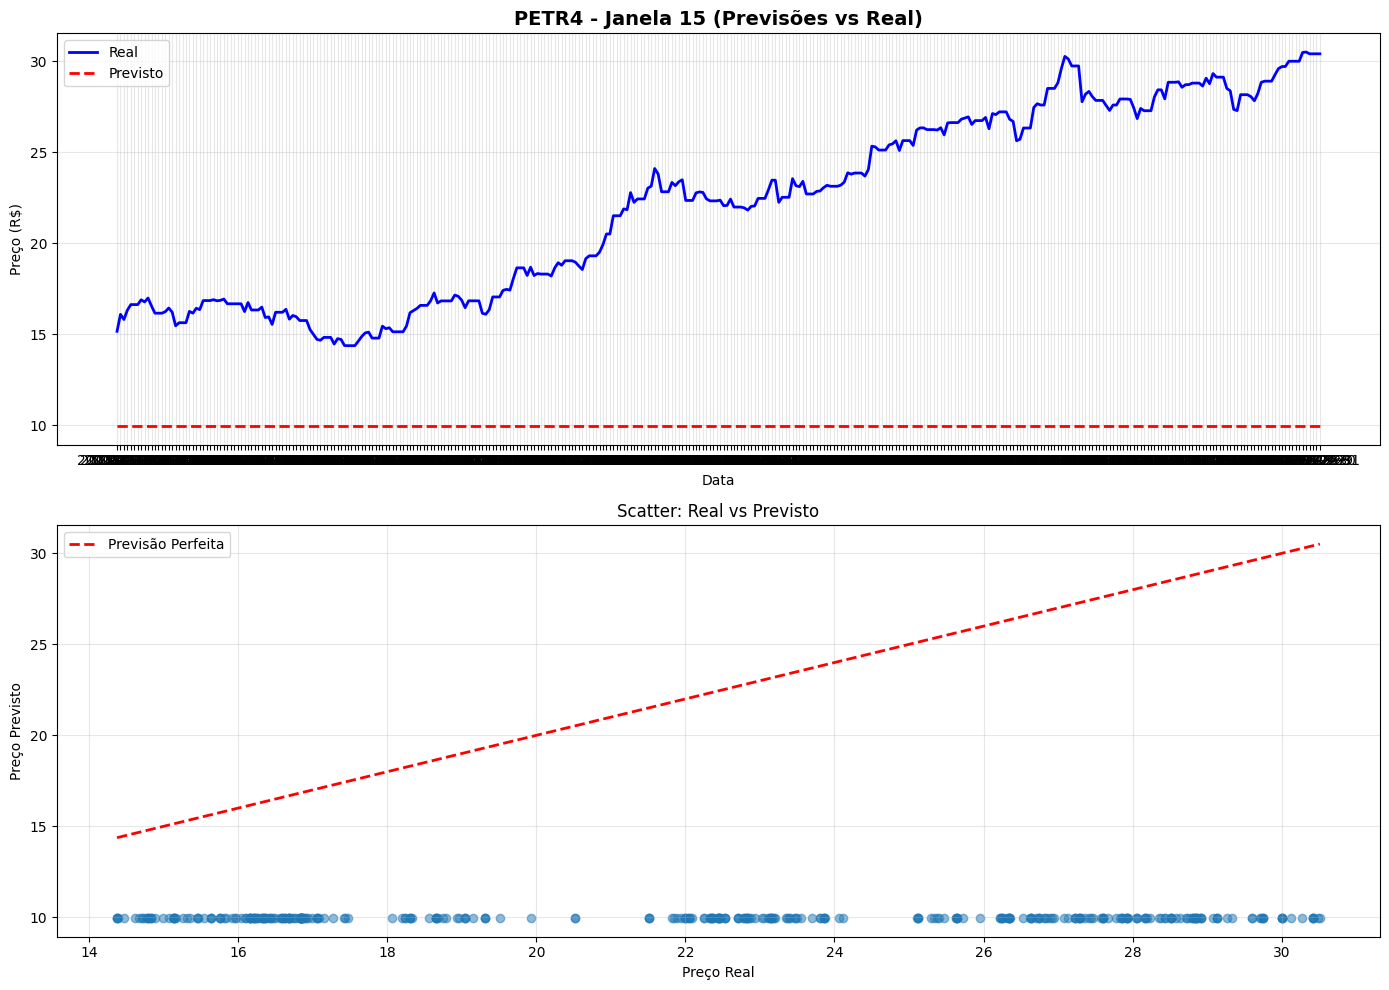


✅ Gráfico salvo em: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoTransformers\resultados_transformer_macromicro/diagnostico_petr4_janela15.png

🔍 VERIFICANDO DADOS DE ENTRADA PETR4

📊 Estatísticas do período de TESTE (2023):


KeyError: "None of [Index(['Close_Target'], dtype='object')] are in the [columns]"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

resultados_dir = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoTransformers\resultados_transformer_macromicro"

# Carregar todas as métricas de PETR4
petr4_metricas = []
for arquivo in os.listdir(resultados_dir):
    if arquivo.startswith('PETR4') and arquivo.endswith('_metrics.csv'):
        df = pd.read_csv(os.path.join(resultados_dir, arquivo))
        petr4_metricas.append(df)

df_petr4 = pd.concat(petr4_metricas, ignore_index=True)

print("="*60)
print("📊 MÉTRICAS DE PETR4 POR JANELA")
print("="*60)
print(df_petr4[['Janela', 'R2', 'MAE', 'Prop_Var', 'Travado']].sort_values('Janela'))

# Carregar previsões para análise visual
print("\n" + "="*60)
print("🔍 ANALISANDO PREVISÕES DE PETR4 - JANELA 15")
print("="*60)

previsoes_path = os.path.join(resultados_dir, 'PETR4.SA_Janela_15_previsoes_teste_final.csv')
if os.path.exists(previsoes_path):
    df_prev = pd.read_csv(previsoes_path)
    
    print(f"\n📈 Estatísticas das Previsões:")
    print(f"Preço Real - Média: {df_prev['Preço Real'].mean():.2f}, Std: {df_prev['Preço Real'].std():.2f}")
    print(f"Preço Previsto - Média: {df_prev['Preço Previsto'].mean():.2f}, Std: {df_prev['Preço Previsto'].std():.2f}")
    
    print(f"\n🎯 Primeiras 10 Previsões:")
    print(df_prev.head(10).to_string(index=False))
    
    print(f"\n🎯 Últimas 10 Previsões:")
    print(df_prev.tail(10).to_string(index=False))
    
    # Verificar se está travado em valor fixo
    unique_preds = df_prev['Preço Previsto'].nunique()
    print(f"\n⚠️  Número de valores únicos nas previsões: {unique_preds}")
    
    if unique_preds < 10:
        print(f"❌ MODELO TRAVADO! Prevendo apenas {unique_preds} valores diferentes")
        print(f"Valores previstos: {df_prev['Preço Previsto'].unique()}")
    
    # Gráfico
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Série temporal
    axes[0].plot(df_prev['Data'], df_prev['Preço Real'], label='Real', color='blue', linewidth=2)
    axes[0].plot(df_prev['Data'], df_prev['Preço Previsto'], label='Previsto', color='red', linestyle='--', linewidth=2)
    axes[0].set_title('PETR4 - Janela 15 (Previsões vs Real)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Data')
    axes[0].set_ylabel('Preço (R$)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Scatter plot (Real vs Previsto)
    axes[1].scatter(df_prev['Preço Real'], df_prev['Preço Previsto'], alpha=0.5)
    axes[1].plot([df_prev['Preço Real'].min(), df_prev['Preço Real'].max()], 
                 [df_prev['Preço Real'].min(), df_prev['Preço Real'].max()], 
                 'r--', linewidth=2, label='Previsão Perfeita')
    axes[1].set_xlabel('Preço Real')
    axes[1].set_ylabel('Preço Previsto')
    axes[1].set_title('Scatter: Real vs Previsto')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{resultados_dir}/diagnostico_petr4_janela15.png", dpi=150)
    plt.show()
    
    print(f"\n✅ Gráfico salvo em: {resultados_dir}/diagnostico_petr4_janela15.png")

# Comparar com dados de entrada
print("\n" + "="*60)
print("🔍 VERIFICANDO DADOS DE ENTRADA PETR4")
print("="*60)

pasta_dados = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\dados_unificados"
dados_path = os.path.join(pasta_dados, "PETR4.SA_dados_macro_micro.csv")

if os.path.exists(dados_path):
    df_dados = pd.read_csv(dados_path, index_col=0, parse_dates=True)
    
    # Período de teste (2023)
    df_teste = df_dados.loc['2023-01-01':'2023-12-31']
    
    print(f"\n📊 Estatísticas do período de TESTE (2023):")
    print(df_teste[['Close_Target']].describe())
    
    print(f"\n📊 Variação no período de teste:")
    print(f"Mínimo: {df_teste['Close_Target'].min():.2f}")
    print(f"Máximo: {df_teste['Close_Target'].max():.2f}")
    print(f"Variação %: {((df_teste['Close_Target'].max() - df_teste['Close_Target'].min()) / df_teste['Close_Target'].min() * 100):.2f}%")
    
    # Verificar correlação entre features
    if 'Close_Feature' in df_teste.columns:
        print(f"\n🔗 Correlação Close_Feature vs Close_Target: {df_teste['Close_Feature'].corr(df_teste['Close_Target']):.4f}")